# NetCDF Zarr Multi-Variable Sequential Recipe: NOAA World Ocean Atlas

This recipe is a little bit more complicated than the {doc}`netcdf_zarr_sequential`.
You shold probably review that one first; here we will skip the basics.

For this example, we will use data from NOAA's [World Ocean Atlas](https://www.ncei.noaa.gov/products/world-ocean-atlas).
As we can see from the [data access page](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl), the dataset is spread over many different files.
What's important here is that:
- There is a time sequence (month) to the files.
- Different variables live in different files.

Because our dataset is spread over muliple files, we will have to use a more complex File Pattern than the previous example.

## Step 1: Get to know your source data

This step can't be skipped! It's impossible to write a recipe if you don't understand intimately how the source data are organized.
World Ocean Atlass has eight different variables: Temperature, Salinity, Dissolved Oxygen, Percent Oxygen Saturation, Apparent Oxygen Utilization, Silicate, Phosphate, Nitrate.
Each variable has a page that looks like this:

![screenshot from NCEI website](ncei-woa-screenshot.png)

For the purpose of this tutorial, we will use the 5-degree resolution monthly data.
We can follow the links to finally find an HTTP download link for a single month of data.

In [1]:
download_url = 'https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc'

Let's download it and try to open it with xarray.

In [2]:
! wget https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc

--2021-07-19 16:38:53--  https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc
Resolving www.ncei.noaa.gov... 205.167.25.171, 205.167.25.168, 205.167.25.167, ...
Connecting to www.ncei.noaa.gov|205.167.25.171|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 2389903 (2.3M) [application/x-netcdf]
Saving to: ‘woa18_decav_t01_5d.nc’

woa18_decav_t01_5d. 100%[===================>]   2.28M   811KB/s    in 2.9s    

2021-07-19 16:38:57 (811 KB/s) - ‘woa18_decav_t01_5d.nc’ saved [2389903/2389903]



In [3]:
%xmode minimal
import xarray as xr
ds = xr.open_dataset("woa18_decav_t01_5d.nc")

Exception reporting mode: Minimal


ValueError: unable to decode time units 'months since 1955-01-01 00:00:00' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.

❗️ Oh no, we got an error!

This is a very common problem. The calendar is encoded using "months since" units, which are ambiguous in the [CF Conventions](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html#calendar). (The precise length of a month is variable by month an year.)

We will follow the advice and do

In [5]:
ds = xr.open_dataset("woa18_decav_t01_5d.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 36, lon: 72, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float32 372.5
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         PRERELEASE Climatological mean temperatu...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA18/pr_wo...
    date_created:                    2018-02-19 
    date_modified:                   2018-02-19

In [6]:
ds.time

<xarray.DataArray 'time' (time: 1)>
array([372.5], dtype=float32)
Coordinates:
  * time     (time) float32 372.5
Attributes:
    standard_name:  time
    long_name:      time
    units:          months since 1955-01-01 00:00:00
    axis:           T
    climatology:    climatology_bounds

We have opened the data, but the time coordinate is just a number, not an actual datetime object.
We can work around this issue by explicitly specifying the `360_day` calendar (in which every month is assumed to have 30 days).

In [7]:
ds.time.attrs['calendar'] = '360_day'
ds = xr.decode_cf(ds)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 36, lon: 72, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) object 1986-01-16 00:00:00
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         PRERELEASE Climatological mean temperatu...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA18/pr_wo...
    date_created:                    2018-02-19 
    date_modified:                   2018-02-19

In [8]:
ds.time

<xarray.DataArray 'time' (time: 1)>
array([cftime.Datetime360Day(1986, 1, 16, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1986-01-16 00:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    climatology:    climatology_bounds

We will need this trick for later.

## Step 2: Define the File Pattern

We can browse through the files on the website and see how they are organized.

```
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t02_5d.nc
...
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/salinity/decav/5deg/woa18_decav_s01_5d.nc
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/salinity/decav/5deg/woa18_decav_s02_5d.nc
...
```

From this we can deduce the general pattern.
We write a function to return the correct filename for a given variable / month combination.

In [9]:
# Here it is important that the function argument name "time" match
# the name of the  dataset dimension "time"
def format_function(variable, time):
    return ("https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/"
            f"{variable}/decav/5deg/woa18_decav_{variable[0]}{time:02d}_5d.nc")

format_function("temperature", 2)

'https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t02_5d.nc'

Now we turn this into a `FilePattern` object.
This pattern has two distinct `combine_dims`: variable name and month.
We want to merge over variable names and concatenate over months. 

In [10]:
from pangeo_forge_recipes import patterns

variable_merge_dim = patterns.MergeDim("variable", keys=["temperature", "salinity"])

# Here it is important that the ConcatDim name "time" match the name of the 
# dataset dimension "time" (and the argument name in format_function)
month_concat_dim = patterns.ConcatDim("time", keys=list(range(1, 13)), nitems_per_file=1)

pattern = patterns.FilePattern(format_function, variable_merge_dim, month_concat_dim)
pattern

<FilePattern {'variable': 2, 'time': 12}>

## Step 3: Write the Recipe

Now that we have a `FilePattern`, we are ready to write our `XarrayZarrRecipe`.

### Define an Input Preprocessor Function

Above we noted that the time was encoded wrong in the original data.
We might have also noticed that many variables that seems like coordinates (e.g. `lat_bnds`) were in the Data Variables part of the dataset.
We will write a function that fixes both these issues.

In [11]:
def fix_encoding_and_attrs(ds, fname):
    ds.time.attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds)
    ds = ds.set_coords(['crs', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'])
    return ds

### Define the Recipe Object

In [12]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

recipe = XarrayZarrRecipe(
    pattern,
    xarray_open_kwargs={'decode_times': False},
    process_input=fix_encoding_and_attrs
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'variable': 2, 'time': 12}>, inputs_per_chunk=1, target_chunks={}, target=None, input_cache=None, metadata_cache=None, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, xarray_open_kwargs={'decode_times': False}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={}, process_input=<function fix_encoding_and_attrs at 0x7fafa00c1430>, process_chunk=None, lock_timeout=None, subset_inputs={})

### Assign Storage

The recipe needs a place to cache the inputs and store the target data.

In [13]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

recipe.input_cache = cache_target
recipe.target = target

## Step 4: Run the Recipe

In {doc}`netcdf_zarr_sequential` we went through each step of recipe execution in detail.
Here we will not do that. He we will let Prefect do the work for us.

In [14]:
flow = recipe.to_prefect()
flow.run()

[2021-07-19 16:39:27+0200] INFO - prefect.FlowRunner | Beginning Flow run for 'pangeo-forge-recipe'
[2021-07-19 16:39:27+0200] INFO - prefect.TaskRunner | Task 'cache_input': Starting task run...
[2021-07-19 16:39:27+0200] INFO - prefect.TaskRunner | Task 'cache_input': Finished task run for task with final state: 'Mapped'
[2021-07-19 16:39:27+0200] INFO - prefect.TaskRunner | Task 'cache_input[0]': Starting task run...
[2021-07-19 16:39:30+0200] INFO - prefect.TaskRunner | Task 'cache_input[0]': Finished task run for task with final state: 'Success'
[2021-07-19 16:39:30+0200] INFO - prefect.TaskRunner | Task 'cache_input[1]': Starting task run...
[2021-07-19 16:39:33+0200] INFO - prefect.TaskRunner | Task 'cache_input[1]': Finished task run for task with final state: 'Success'
[2021-07-19 16:39:33+0200] INFO - prefect.TaskRunner | Task 'cache_input[2]': Starting task run...
[2021-07-19 16:39:35+0200] INFO - prefect.TaskRunner | Task 'cache_input[2]': Finished task run for task with fi

<Success: "All reference tasks succeeded.">

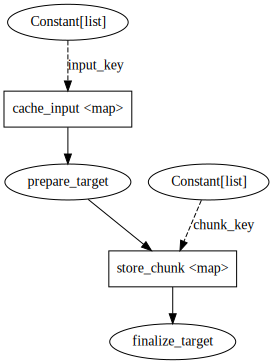

In [15]:
flow.visualize()

## Step 5: Check the Target

All the data should be there!

In [16]:
ds = xr.open_zarr(target_dir.name)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 36, lon: 72, nbounds: 2, time: 12)
Coordinates:
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    crs                 int32 ...
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(57, 2), meta=np.ndarray>
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(36, 2), meta=np.ndarray>
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(72, 2), meta=np.ndarray>
  * time                (time) object 1986-01-16 00:00:00 ... 1986-12-16 00:0...
Dimensions without coordinates: nbounds
Data variables:
    s_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    cdm_data_type:                   Grid
    comment:                         global climatology as part of the World ...
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    creator_email:                   NCEI.info@noaa.gov
    ...                              ...
    summary:                         Climatological mean salinity for the glo...
    time_coverage_duration:          P63Y
    time_coverage_end:               2017-01-31
    time_coverage_resolution:        P01M
    time_coverage_start:             1955-01-01
    title:                           World Ocean Atlas 2018 : sea_water_salin...

Just to check, we will make a plot.

/opt/miniconda3/envs/pangeo-forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


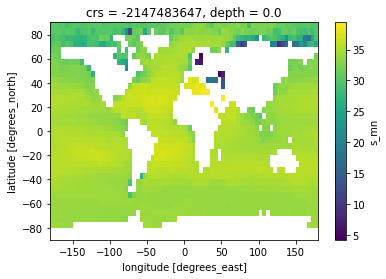

In [17]:
ds.s_mn.isel(depth=0).mean(dim='time').plot()

🎉 Yay! Our recipe worked!